In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(stringi)
library(cowplot)


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union




# Load data

In [2]:
dat5c <- read.csv("out/dat5c.csv")
dat5c <- dat5c[,c(1,2,3,4,7,8)]
colnames(dat5c) <- c("city", "variant", "index", "count", "frac", "count_tot3")
dat5c <- mutate(dat5c, variant = replace(variant, variant == "B.1.1.28", "P.1"))
head(dat5c)

city variant   index      count frac count_tot3
1 Bern P.1       2020-03-04 0     NA   0         
2 Bern B.1.1.7   2020-03-04 0     NA   0         
3 Bern B.1.351   2020-03-04 0     NA   0         
4 Bern B.1.617.1 2020-03-04 0     NA   0         
5 Bern B.1.617.2 2020-03-04 0     NA   0         
6 Bern other     2020-03-04 0     NA   0

In [6]:
linear_deconv_df_flat <- read.csv("out/linear_deconv_df_flat.csv")
linear_deconv_df_flat <- mutate(
    linear_deconv_df_flat,
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
linear_deconv_df_flat$city <- linear_deconv_df_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")

colnames(linear_deconv_df_flat)[1] <- "index"
head(linear_deconv_df_flat)

index      city   estimate variant frac       
1 2021-08-25 Ticino MSE      B.1.1.7 0.002713967
2 2021-08-26 Ticino MSE      B.1.1.7 0.002669694
3 2021-08-27 Ticino MSE      B.1.1.7 0.002698547
4 2021-08-28 Ticino MSE      B.1.1.7 0.002783400
5 2021-08-29 Ticino MSE      B.1.1.7 0.002902020
6 2021-08-30 Ticino MSE      B.1.1.7 0.003033242

In [4]:
robust_deconv_df_flat <- read.csv("out/robust_deconv_df_flat.csv")
robust_deconv_df_flat <- mutate(
    robust_deconv_df_flat,
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
robust_deconv_df_flat$city <- robust_deconv_df_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
head(robust_deconv_df_flat)

index      city   estimate variant frac       
1 2021-08-25 Ticino robust   B.1.1.7 0.001269938
2 2021-08-26 Ticino robust   B.1.1.7 0.001203348
3 2021-08-27 Ticino robust   B.1.1.7 0.001153340
4 2021-08-28 Ticino robust   B.1.1.7 0.001125708
5 2021-08-29 Ticino robust   B.1.1.7 0.001124882
6 2021-08-30 Ticino robust   B.1.1.7 0.001153666

In [7]:
merged_dat <- dat5c %>% merge(
    filter(linear_deconv_df_flat, estimate == "MSE"), 
    by = c("index", "city", "variant"),
    suffixes = c("Clinical", "MSE")
) %>% merge(
    filter(robust_deconv_df_flat, estimate == "robust"), 
    by = c("index", "city", "variant"),
    suffixes = c("", "Robust")
) 
head(merged_dat)

index      city   variant   count fracClinical count_tot3 estimate
1 2021-01-02 Vaud   B.1.1.7   0     0             2         MSE     
2 2021-01-02 Vaud   B.1.351   0     0             2         MSE     
3 2021-01-02 Vaud   B.1.617.2 0     0             2         MSE     
4 2021-01-02 Vaud   P.1       0     0             2         MSE     
5 2021-01-02 Vaud   other     2     1             2         MSE     
6 2021-01-02 Zürich B.1.1.7   0     0            33         MSE     
  fracMSE     estimateRobust frac       
1 0.076632177 robust         0.049680952
2 0.035872619 robust         0.018205176
3 0.007784361 robust         0.004791697
4 0.029344984 robust         0.010129019
5 0.845780843 robust         0.914610218
6 0.066356980 robust         0.054450112

## Plot

Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”


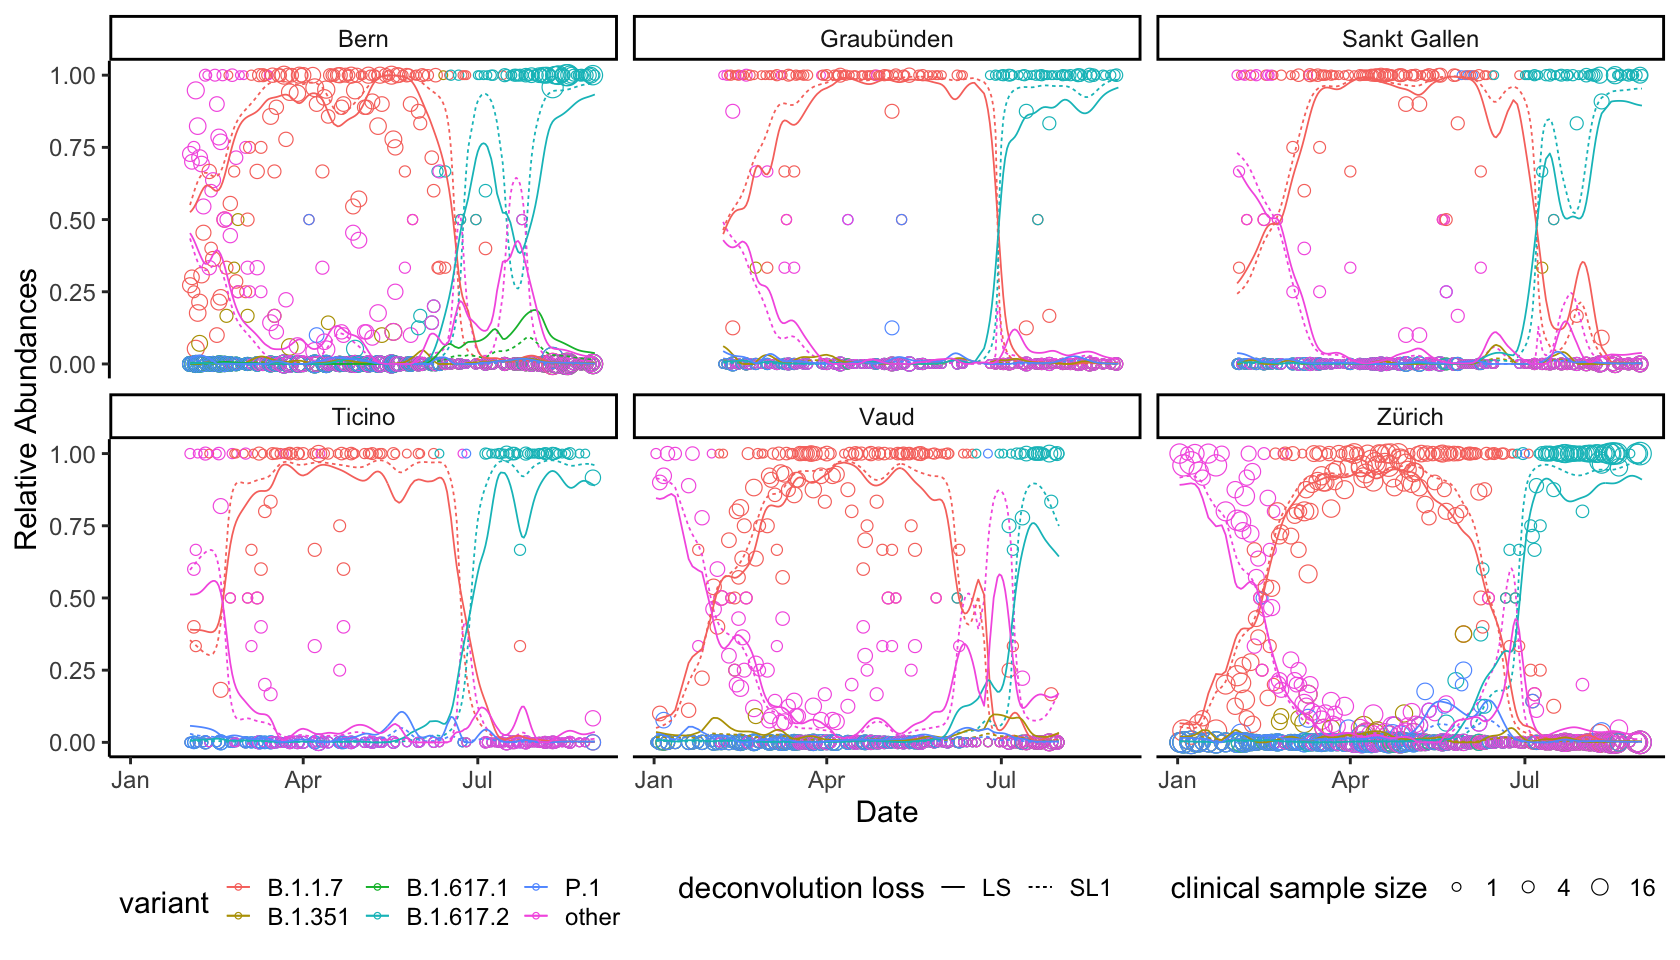

In [9]:
options(repr.plot.width=14, repr.plot.height=8)


line_plot <- merged_dat %>%
    ggplot() + 
        geom_point(aes(
            x=as.Date(index),
            y=fracClinical,
            color=variant,
            size=sqrt(count_tot3)
        ),
                   shape=1
                  ) +
        geom_line(aes(
            x=as.Date(index),
            y=frac,
            color=variant, 
            linetype="SL1"
        )
                  ) +
        geom_line(aes(
            x=as.Date(index),
            y=fracMSE,
            color=variant,
            linetype="LS"
        )
                  ) +
#         xlab("Date") + ylab("Relative Abundances") +
        facet_wrap(~city) +
        theme_classic(base_size = 18) +
        labs(
            x = "Date",
            y = "Relative Abundances",
            linetype = "deconvolution loss",
            size = "clinical sample size"
        )+
        scale_size_area(
            breaks=c(1,2,4),
            labels=c(1,4,16)
        ) +
        theme(legend.position = "bottom") 

line_plot
ggsave("plots/fit_plots.pdf", line_plot, width = 14, height = 8)

### Cross correlations

In [10]:
tt_Df <- na.omit(merged_dat)
tt_Df$index <- as.Date(tt_Df$index)

# aggregate(tt_Df, by=list(tt_Df$index, tt_Df$city, tt_Df$variant), FUN = function(x) cor(x["frac"], x["fracMSE"]))
          
tt_Df2 <- split(tt_Df, list(tt_Df$city, tt_Df$variant))

ccfs <- lapply(tt_Df2, function(x) {
    if (nrow(x) >0){
        vals <- with(x, ccf(fracClinical, frac, plot = FALSE, lag.max = 7))
        
        nclin <- sum(x$count_tot3)
        n <- nrow(x)
        out <- as.data.frame(t(c(n, nclin, vals$acf)))
        colnames(out) <- c("n", "nclin", vals$lag)
        return(out)
    }
    
})
ccfs_df <- Reduce(function(...) rbind(...), ccfs)

# apply(ccfs_df[,3:ncol(ccfs_df)], 2, weighted.mean, weights=ccfs_df$n)

# barplot(apply(ccfs_df[,3:ncol(ccfs_df)], 2, weighted.mean, weights=sqrt(ccfs_df$nclin)))



dts 
3.949456

[1] 0.8654902

dts 
3.286587

[1] 0.861377

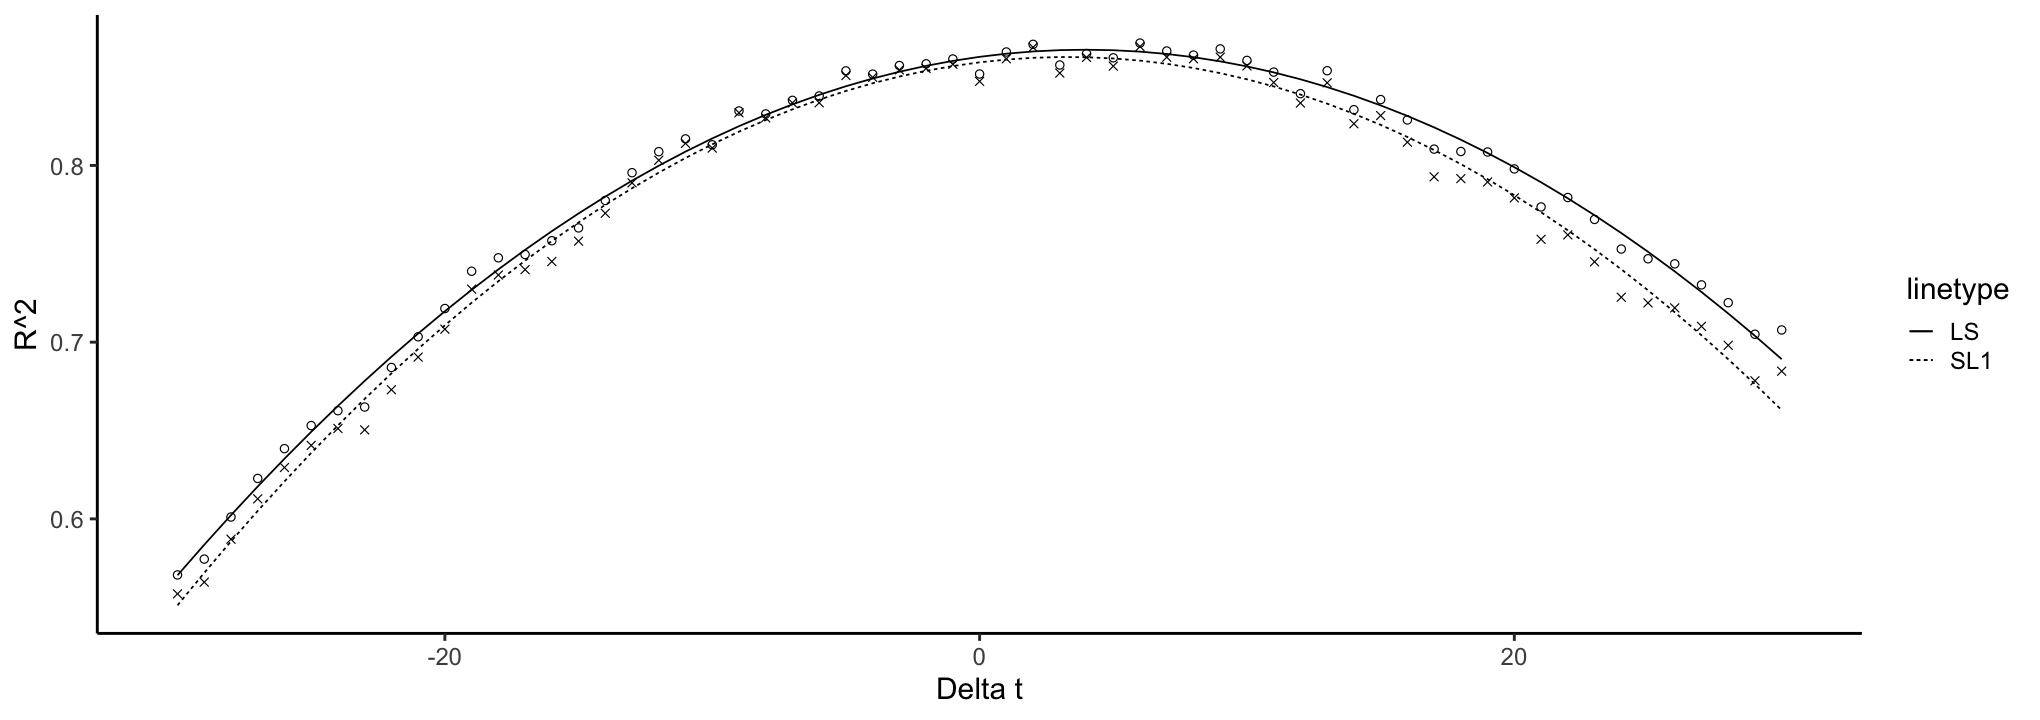

In [11]:
options(repr.plot.width=17, repr.plot.height=6)


cross_corr <- function(dt, tt_Df){
    tt_Df2 <- tt_Df
    tt_Df2$index <- tt_Df2$index - dt
    tt_Df3 <- merge(tt_Df, tt_Df2, by = c("index", "city", "variant"))
    return(tt_Df3)
}

dts <- -30:30

MSEccf <- unlist(lapply(dts, function(x) {
    cordf <- cross_corr(x, tt_Df)
    summary(lm(cordf$fracMSE.x ~ cordf$fracClinical.y, weights = sqrt(cordf$count_tot3.y)))$r.squared
}))

ROBccf <- unlist(lapply(dts, function(x) {
    cordf <- cross_corr(x, tt_Df)
    summary(lm(cordf$frac.x ~ cordf$fracClinical.y, weights = sqrt(cordf$count_tot3.y)))$r.squared
}))

MSEmod1 <- lm(MSEccf ~ I(dts^2) + dts)
ROBmod1 <- lm(ROBccf ~ I(dts^2) + dts)

ccf_plot <- ggplot() +
    geom_point(aes(x=dts, y=MSEccf, shape="LS"), shape=1, size=2) +
#     geom_smooth(aes(x=dts, y=MSEccf, colour="LS")) +
    geom_point(aes(x=dts, y=ROBccf, shape="SL1"), shape=4, size=2) +
    geom_line(aes(x=dts,
                  y=MSEmod1$coefficients[1] + MSEmod1$coefficients[2]*dts^2 + MSEmod1$coefficients[3]*dts,
                 linetype="LS")) + 
    geom_line(aes(x=dts,
                  y=ROBmod1$coefficients[1] + ROBmod1$coefficients[2]*dts^2 + ROBmod1$coefficients[3]*dts,
                 linetype="SL1")) + 
#     scale_y_continuous(limits=c(0.75,0.95)) +
    labs(x=expression("Delta t"), y="R^2") + 
    theme_classic(base_size = 18)
ccf_plot

# MSEmod1$coefficients
# ROBmod1$coefficients

max_MSE <- -MSEmod1$coefficients[3]/(2*MSEmod1$coefficients[2])
max_ROB <- -ROBmod1$coefficients[3]/(2*ROBmod1$coefficients[2])
max_MSE
sum(MSEmod1$coefficients * c(1, max_MSE^2, max_MSE))

max_ROB
sum(ROBmod1$coefficients * c(1, max_ROB^2, max_ROB))


# Model, plot

## Basic LM

### weighted by clinical sample size

In [12]:
mod1b <- lm(
    fracClinical ~ fracMSE,
    data=merged_dat,
    weights = sqrt(merged_dat$count_tot3)
    )
summary(mod1b)

rmod1b <- lm(
    fracClinical ~ frac,
    data=merged_dat,
    weights = sqrt(merged_dat$count_tot3)
    )
summary(rmod1b)


Call:
lm(formula = fracClinical ~ fracMSE, data = merged_dat, weights = sqrt(merged_dat$count_tot3))

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.22301 -0.03338 -0.00185  0.00647  1.17973 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.004917   0.002426  -2.026   0.0428 *  
fracMSE      1.043046   0.006446 161.802   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2162 on 4557 degrees of freedom
  (1392 Beobachtungen als fehlend gelöscht)
Multiple R-squared:  0.8517,	Adjusted R-squared:  0.8517 
F-statistic: 2.618e+04 on 1 and 4557 DF,  p-value: < 2.2e-16



Call:
lm(formula = fracClinical ~ frac, data = merged_dat, weights = sqrt(merged_dat$count_tot3))

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.26760 -0.02744 -0.01359 -0.00754  1.21109 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.006385   0.002426   2.631  0.00853 ** 
frac        0.974912   0.006124 159.188  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2192 on 4557 degrees of freedom
  (1392 Beobachtungen als fehlend gelöscht)
Multiple R-squared:  0.8476,	Adjusted R-squared:  0.8475 
F-statistic: 2.534e+04 on 1 and 4557 DF,  p-value: < 2.2e-16


In [13]:
sqrt(summary(mod1b)$r.squared)
sqrt(summary(rmod1b)$r.squared)

[1] 0.9228988

[1] 0.9206412

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”


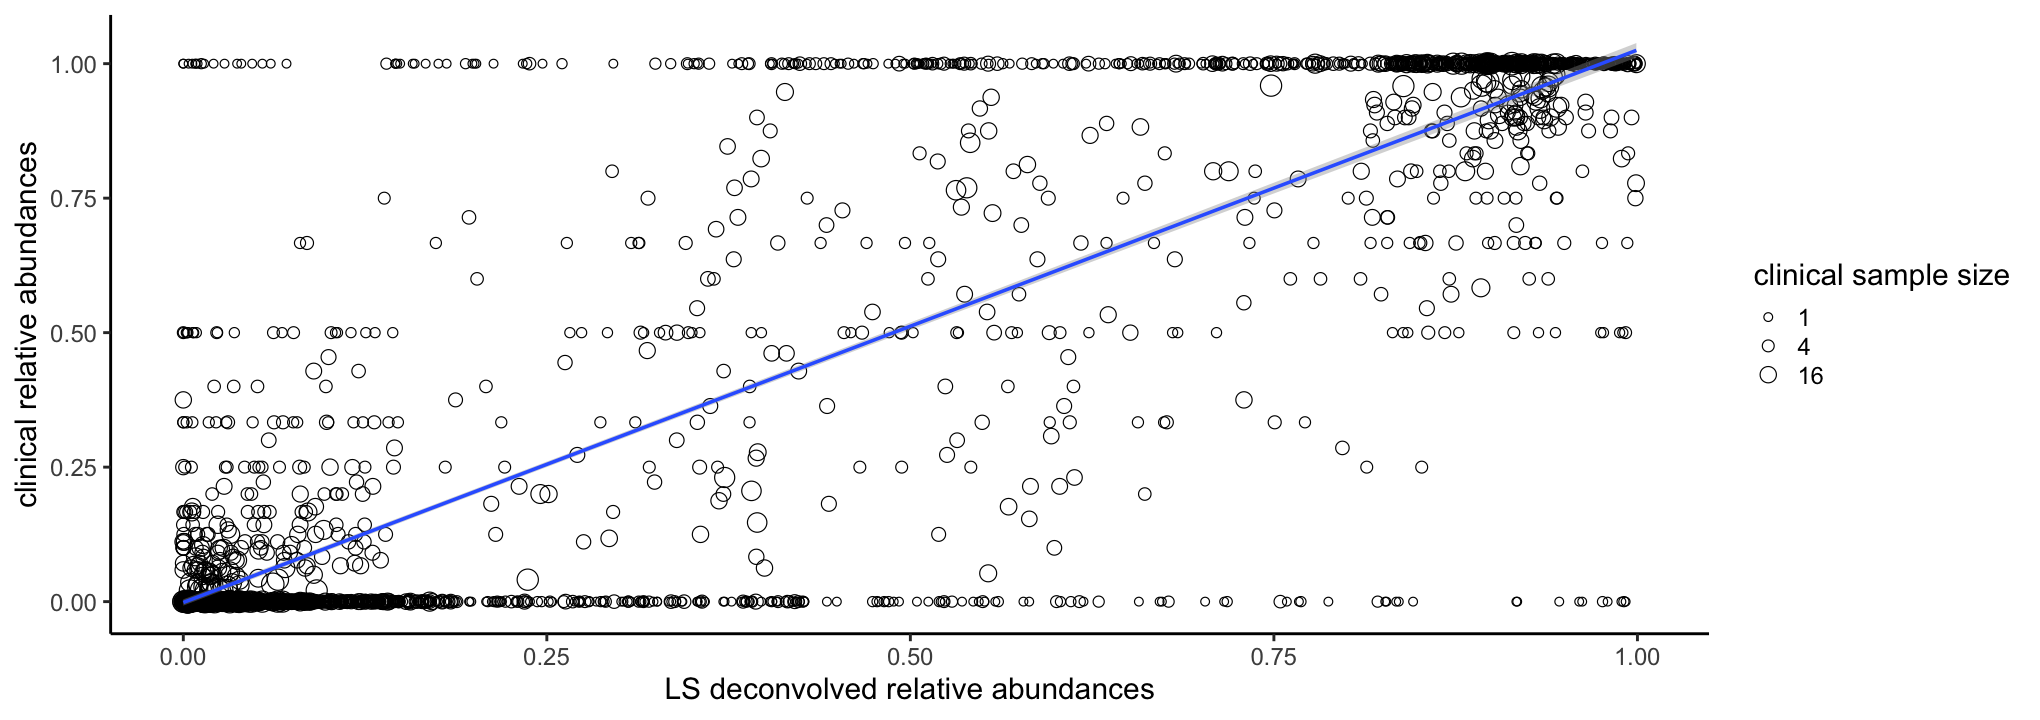

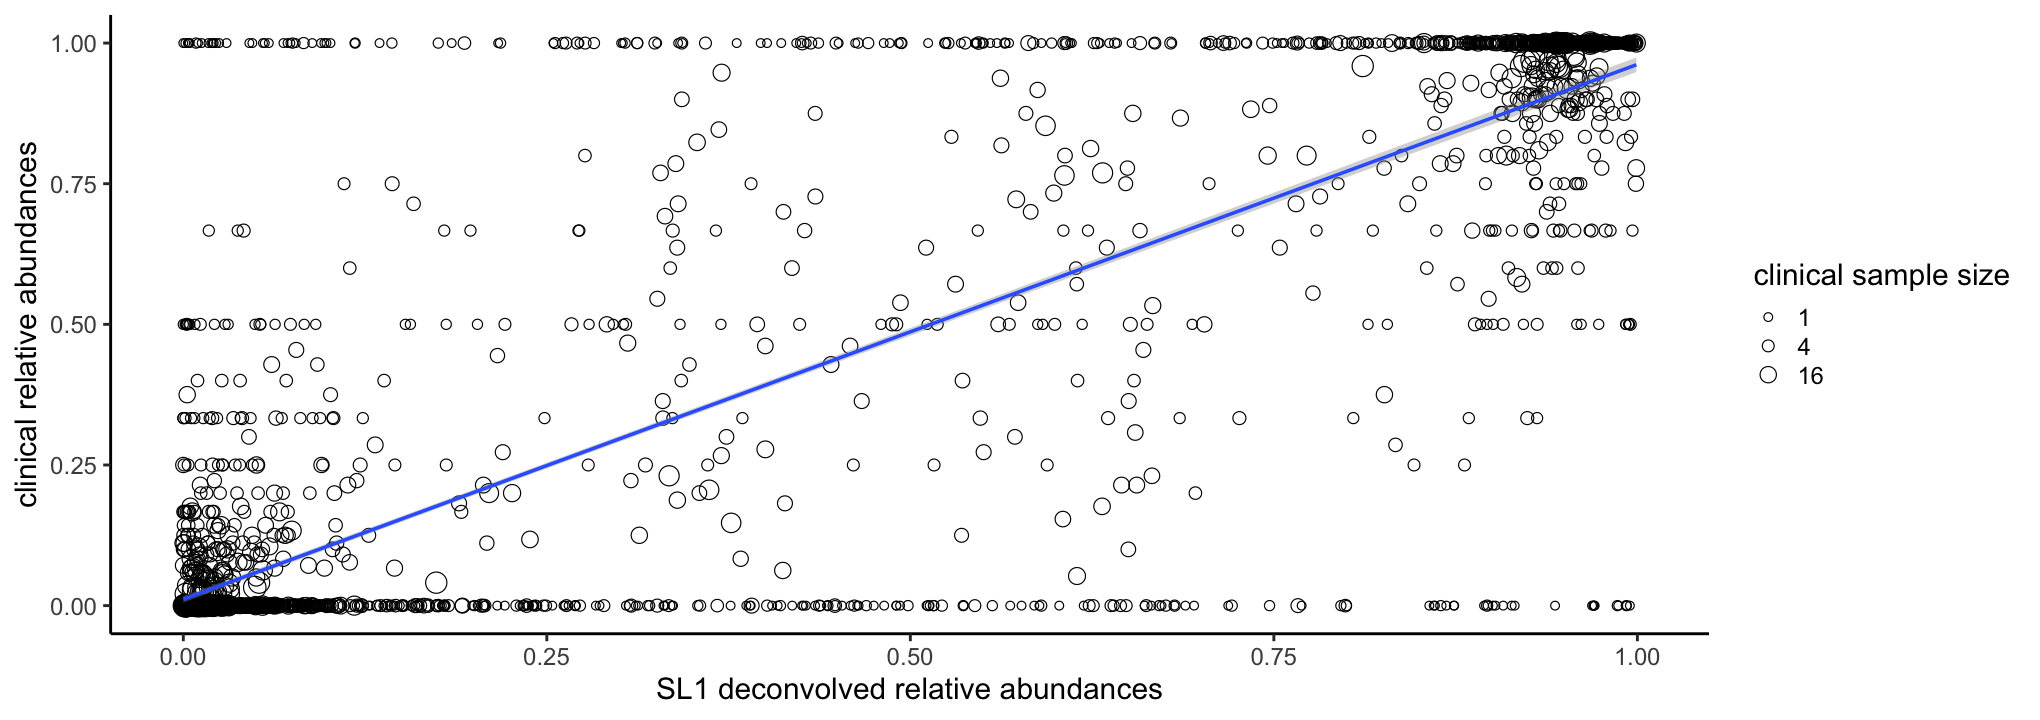

In [14]:
corplot1 <- ggplot(data=merged_dat, aes(x=fracMSE, y=fracClinical)) + 
    geom_point(aes(size=sqrt(count_tot3)), shape=1) +
    geom_smooth(method="lm") +
    theme_classic(base_size = 18) +
    scale_size_area(
            name="clinical sample size",
            breaks=c(1,2,4),
            labels=c(1,4,16)
    )+
    labs(x="LS deconvolved relative abundances", y="clinical relative abundances")

corplot2 <- ggplot(data=merged_dat, aes(x=frac, y=fracClinical)) + 
    geom_point(aes(size=sqrt(count_tot3)), shape=1) +
    geom_smooth(method="lm") +
    theme_classic(base_size = 18) +
    scale_size_area(
            name="clinical sample size",
            breaks=c(1,2,4),
            labels=c(1,4,16)
    ) +
    labs(x="SL1 deconvolved relative abundances", y="clinical relative abundances")


corplot1
corplot2

# Hyperparameters

### Load data

In [15]:
linear_deconv_df_hyperparam <- read.csv("out/linear_deconv_df_hyperparam.csv")

In [16]:
linear_deconv_df_hyperparam_flat <- reshape2::melt(
    data= linear_deconv_df_hyperparam,
    id.vars = c("city", "k", "X"),
    measure.vars = c("B.1.1.7", "B.1.351", "P.1", "B.1.617.2", "B.1.617.1", "undetermined"),
    variable.name="variant",
    value.name="frac"
    )  %>% 
rename(index=X) %>% mutate(
    variant = str_replace(
        variant,
        "undetermined",
        "other")
)

linear_deconv_df_hyperparam_flat$city <- linear_deconv_df_hyperparam_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
# head(linear_deconv_df_hyperparam_flat)

In [17]:
linear_deconv_df_hyperparam_flat2 <- dat5c %>% merge(
    linear_deconv_df_hyperparam_flat,
    by = c("index", "city", "variant"),
    suffixes = c("Clinical", "MSE")
)
linear_deconv_df_hyperparam_flat2$fracMSE <- as.numeric(linear_deconv_df_hyperparam_flat2$fracMSE)
# head(linear_deconv_df_hyperparam_flat2)

#### rob

In [18]:
robust_deconv_df_hyperparam <- read.csv("out/robust_deconv_df_hyperparam2.csv")
# head(linear_deconv_df_hyperparam)
robust_deconv_df_hyperparam_flat <- reshape2::melt(
    data= robust_deconv_df_hyperparam,
    id.vars = c("city", "k", "kappa", "X"),
    measure.vars = c("B.1.1.7", "B.1.351", "P.1", "B.1.617.2", "B.1.617.1", "undetermined"),
    variable.name="variant",
    value.name="frac"
    )  %>% 
rename(index=X) %>% mutate(
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
robust_deconv_df_hyperparam_flat$city <- robust_deconv_df_hyperparam_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
# head(linear_deconv_df_hyperparam_flat)

Warning message in `[<-.factor`(`*tmp*`, list, value = "other"):
“ungültiges Faktorniveau, NA erzeugt”


In [19]:
robust_deconv_df_hyperparam_flat2 <- dat5c %>% merge(
    robust_deconv_df_hyperparam_flat,
    by = c("index", "city", "variant"),
    suffixes = c("Clinical", "MSE"))
robust_deconv_df_hyperparam_flat2$fracMSE <- as.numeric(robust_deconv_df_hyperparam_flat2$fracMSE)
# head(linear_deconv_df_hyperparam_flat2)

### model

In [20]:
linear_deconv_df_hyperparam_flat2_split <- split(linear_deconv_df_hyperparam_flat2, linear_deconv_df_hyperparam_flat2$k)

In [21]:
linear_mods <- lapply(names(linear_deconv_df_hyperparam_flat2_split), function(k){
    t_dat <- linear_deconv_df_hyperparam_flat2_split[[k]] %>% filter(
            variant != "other"
        )
    t_mod <- lm(
        fracClinical ~ fracMSE,
        data=t_dat,
        weights = sqrt(t_dat$count_tot3)
    )
    data.frame(
                k = k,
                r.squared = summary(t_mod)["r.squared"],
                coef = coef(t_mod)[2],
                bias = weighted.mean(t_dat$fracClinical - t_dat$fracMSE, sqrt(t_dat$count_tot3), na.rm = TRUE)
            )
})
lin_mods_df <- as.data.frame(Reduce(function(...) rbind.data.frame(...), linear_mods))


In [22]:
robust_deconv_df_hyperparam_flat2_split <- split(robust_deconv_df_hyperparam_flat2, robust_deconv_df_hyperparam_flat2$k)
robust_deconv_df_hyperparam_flat2_split <- lapply(robust_deconv_df_hyperparam_flat2_split, function(x) split(x, x$kappa))

In [23]:
robust_mods <- lapply(names(robust_deconv_df_hyperparam_flat2_split), function(k){
    tt_dat <- robust_deconv_df_hyperparam_flat2_split[[k]]
    lapply(names(tt_dat), function(kappa){
        t_dat <- tt_dat[[kappa]] %>% filter(
            variant != "other"
        )
        t_mod <- lm(
            fracClinical ~ fracMSE,
            data=t_dat,
            weights = sqrt(t_dat$count_tot3)
        )
        data.frame(
                k = k,
                kappa = kappa,
                r.squared = summary(t_mod)["r.squared"],
                coef = coef(t_mod)[2],
                bias = weighted.mean(t_dat$fracClinical - t_dat$fracMSE, sqrt(t_dat$count_tot3))
            )
        })
})
robust_mods_df <- as.data.frame(Reduce(function(...) rbind.data.frame(...),
                         lapply(robust_mods, function(x) Reduce(function(...) rbind.data.frame(...), x))))


In [24]:
tt1 <- split(robust_mods_df, robust_mods_df$k)
Reduce(function(...) rbind(...), lapply(tt1, function(x) x[which.max(x$r.squared), ]))

k     kappa               r.squared coef     bias       
fracMSE6  0.001 0.2575              0.8908291 1.004340 0.003962859
fracMSE41 10.0  0.17500000000000002 0.9297150 1.018027 0.002187944
fracMSE42 15.0  0.17500000000000002 0.9311586 1.018955 0.002093031
fracMSE33 20.0  0.13375             0.9323274 1.011705 0.001831973
fracMSE34 25.0  0.13375             0.9331718 1.012272 0.001730001
fracMSE36 30.0  0.13375             0.9338125 1.012711 0.001627548
fracMSE38 5.0   0.13375             0.9282897 1.009367 0.002132503

Warning message:
“Ignoring unknown parameters: interpolate”
Warning message:
“Ignoring unknown parameters: interpolate”


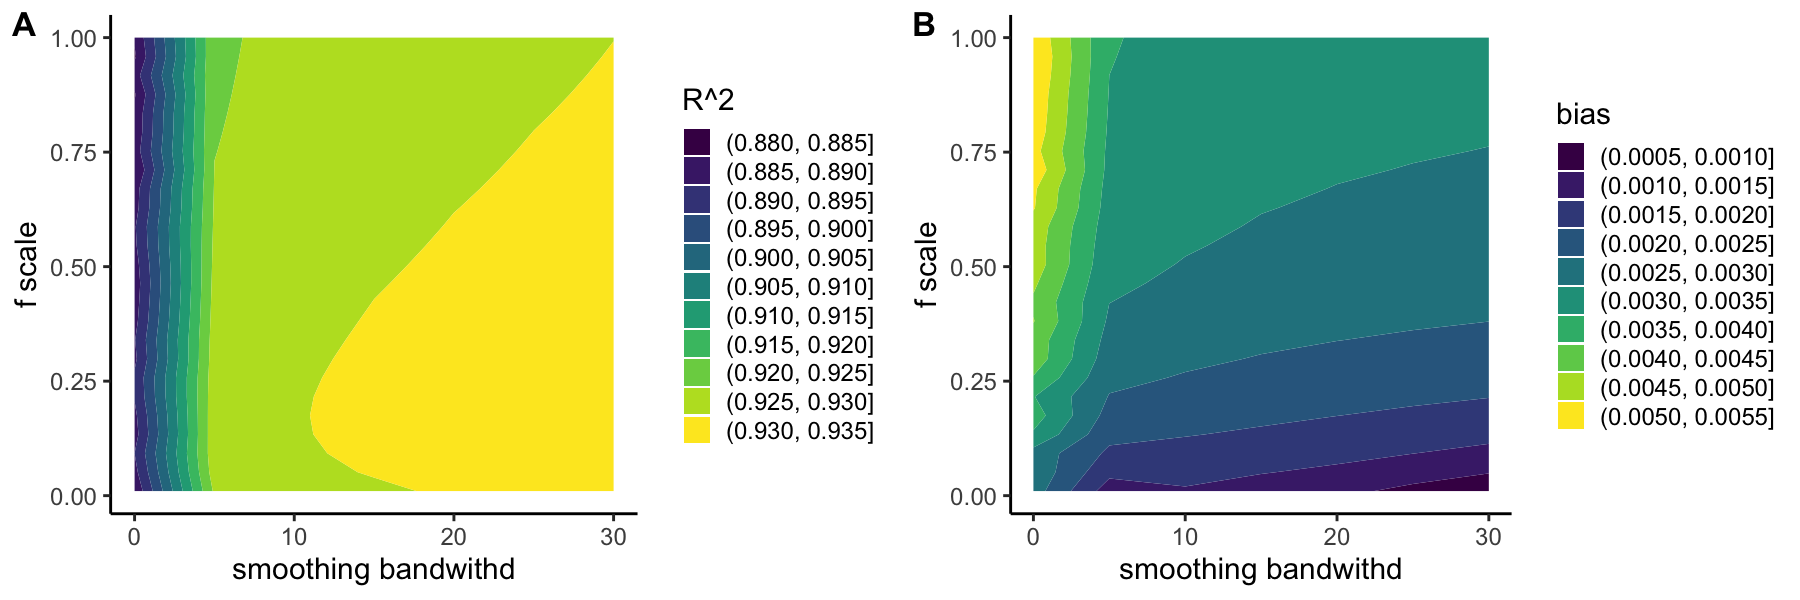

In [26]:
options(repr.plot.width=15, repr.plot.height=5)


rob_plt1 <- ggplot(data = robust_mods_df) + 
    geom_contour_filled(
     aes(
         x=as.numeric(k),
         y=as.numeric(kappa),
         z=r.squared),
     interpolate = TRUE
 ) +
    theme_classic(base_size = 18) +
 xlab("smoothing bandwithd") + ylab("f scale") + 
 guides(fill=guide_legend("R^2")) 


rob_plt2 <- ggplot(data = robust_mods_df) + 
    geom_contour_filled(
     aes(
         x=as.numeric(k),
         y=as.numeric(kappa),
         z=bias),
     interpolate = TRUE
 ) +
    theme_classic(base_size = 18) +
 xlab("smoothing bandwithd") + ylab("f scale") + 
 guides(fill=guide_legend("bias")) 

plt_rob_hyperparams <- plot_grid(rob_plt1, rob_plt2, nrow = 1, labels = LETTERS[1:2], label_size = 20)
plt_rob_hyperparams
ggsave("plots/plt_rob_hyperparams.pdf", plt_rob_hyperparams, width=15, height = 5)

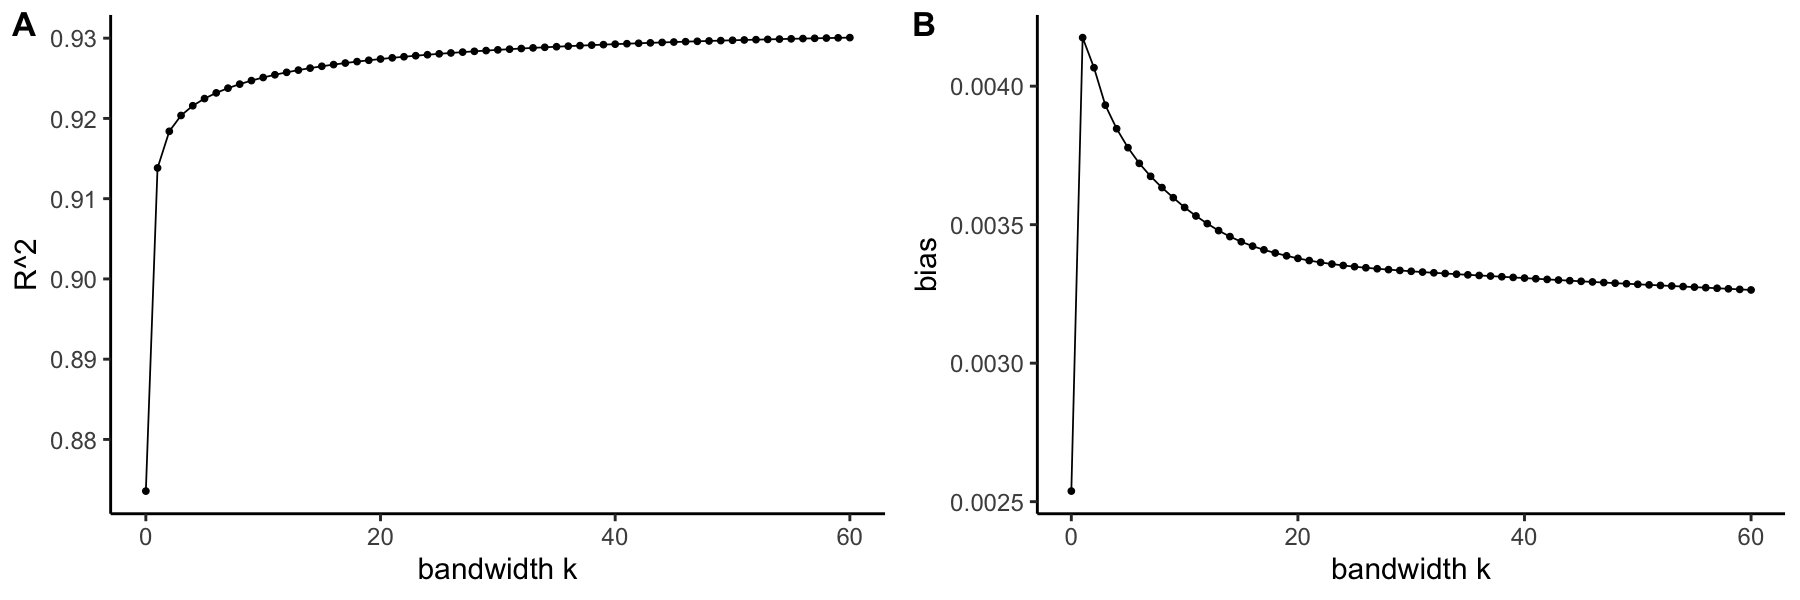

In [27]:
options(repr.plot.width=15, repr.plot.height=5)


lin_plt1 <- ggplot(data = lin_mods_df) + 
    geom_line(aes(x=as.numeric(k), y=r.squared)) +
    geom_point(aes(x=as.numeric(k), y=r.squared)) + 
    xlab("bandwidth k") + ylab("R^2") + 
    theme_classic(base_size = 18)

lin_plt2 <- ggplot(data = lin_mods_df) + 
    geom_line(aes(x=as.numeric(k), y=bias)) + 
    geom_point(aes(x=as.numeric(k), y=bias)) + 
    xlab("bandwidth k") + ylab("bias") + 
    theme_classic(base_size = 18)

plt_mse_hyperparams <- plot_grid(lin_plt1, lin_plt2, nrow=1, labels=LETTERS[1:2], label_size=20)
plt_mse_hyperparams
ggsave("plots/plt_mse_hyperparams.pdf", plt_mse_hyperparams, width=15, height = 5)

## Confint plots

In [28]:
linear_deconv3_df_boot_flat = read.csv("out/linear_deconv3_df_boot_flat.csv")

linear_deconv3_df_boot_flat <- mutate(
    linear_deconv3_df_boot_flat,
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
linear_deconv3_df_boot_flat$city <- linear_deconv3_df_boot_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
head(linear_deconv3_df_boot_flat)

X city         index      variant   estimate frac     
1 0 Sankt Gallen 2021-02-01 B.1.1.7   lower    0.1958589
2 1 Sankt Gallen 2021-02-01 B.1.351   lower    0.0000000
3 2 Sankt Gallen 2021-02-01 B.1.617.1 lower    0.0000000
4 3 Sankt Gallen 2021-02-01 B.1.617.2 lower    0.0000000
5 4 Sankt Gallen 2021-02-01 P.1       lower    0.0000000
6 5 Sankt Gallen 2021-02-01 other     lower    0.5331378

In [29]:
linear_deconv_quasi2_df_flat <- read.csv("out/linear_deconv_quasi2_df_flat.csv")
linear_deconv_quasi2_df_flat <- mutate(
    linear_deconv_quasi2_df_flat,
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
linear_deconv_quasi2_df_flat$city <- linear_deconv_quasi2_df_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
head(linear_deconv_quasi2_df_flat)

X          city   estimate variant frac       
1 2021-08-25 Ticino MSE      B.1.1.7 0.002713967
2 2021-08-26 Ticino MSE      B.1.1.7 0.002669694
3 2021-08-27 Ticino MSE      B.1.1.7 0.002698547
4 2021-08-28 Ticino MSE      B.1.1.7 0.002783400
5 2021-08-29 Ticino MSE      B.1.1.7 0.002902020
6 2021-08-30 Ticino MSE      B.1.1.7 0.003033242

In [30]:
linear_deconv2_df_flat <- read.csv("out/linear_deconv2_quasi2_df_flat.csv")
linear_deconv2_df_flat <- mutate(
    linear_deconv2_df_flat,
    variant = replace(
        variant,
        variant == "undetermined",
        "other")
)
linear_deconv2_df_flat$city <- linear_deconv2_df_flat$city %>%
    str_replace(fixed("Lugano (TI)"), "Ticino") %>%
    str_replace(fixed("Zürich (ZH)"), "Zürich") %>%
    str_replace(fixed("Chur (GR)"), "Graubünden") %>%
    str_replace(fixed("Altenrhein (SG)"), "Sankt Gallen") %>%
    str_replace(fixed("Laupen (BE)"), "Bern") %>%
    str_replace(fixed("Lausanne (VD)"), "Vaud")
head(linear_deconv2_df_flat)

X          city   estimate variant frac       
1 2021-08-25 Ticino MSE      B.1.1.7 0.002713967
2 2021-08-26 Ticino MSE      B.1.1.7 0.002669694
3 2021-08-27 Ticino MSE      B.1.1.7 0.002698547
4 2021-08-28 Ticino MSE      B.1.1.7 0.002783400
5 2021-08-29 Ticino MSE      B.1.1.7 0.002902020
6 2021-08-30 Ticino MSE      B.1.1.7 0.003033242

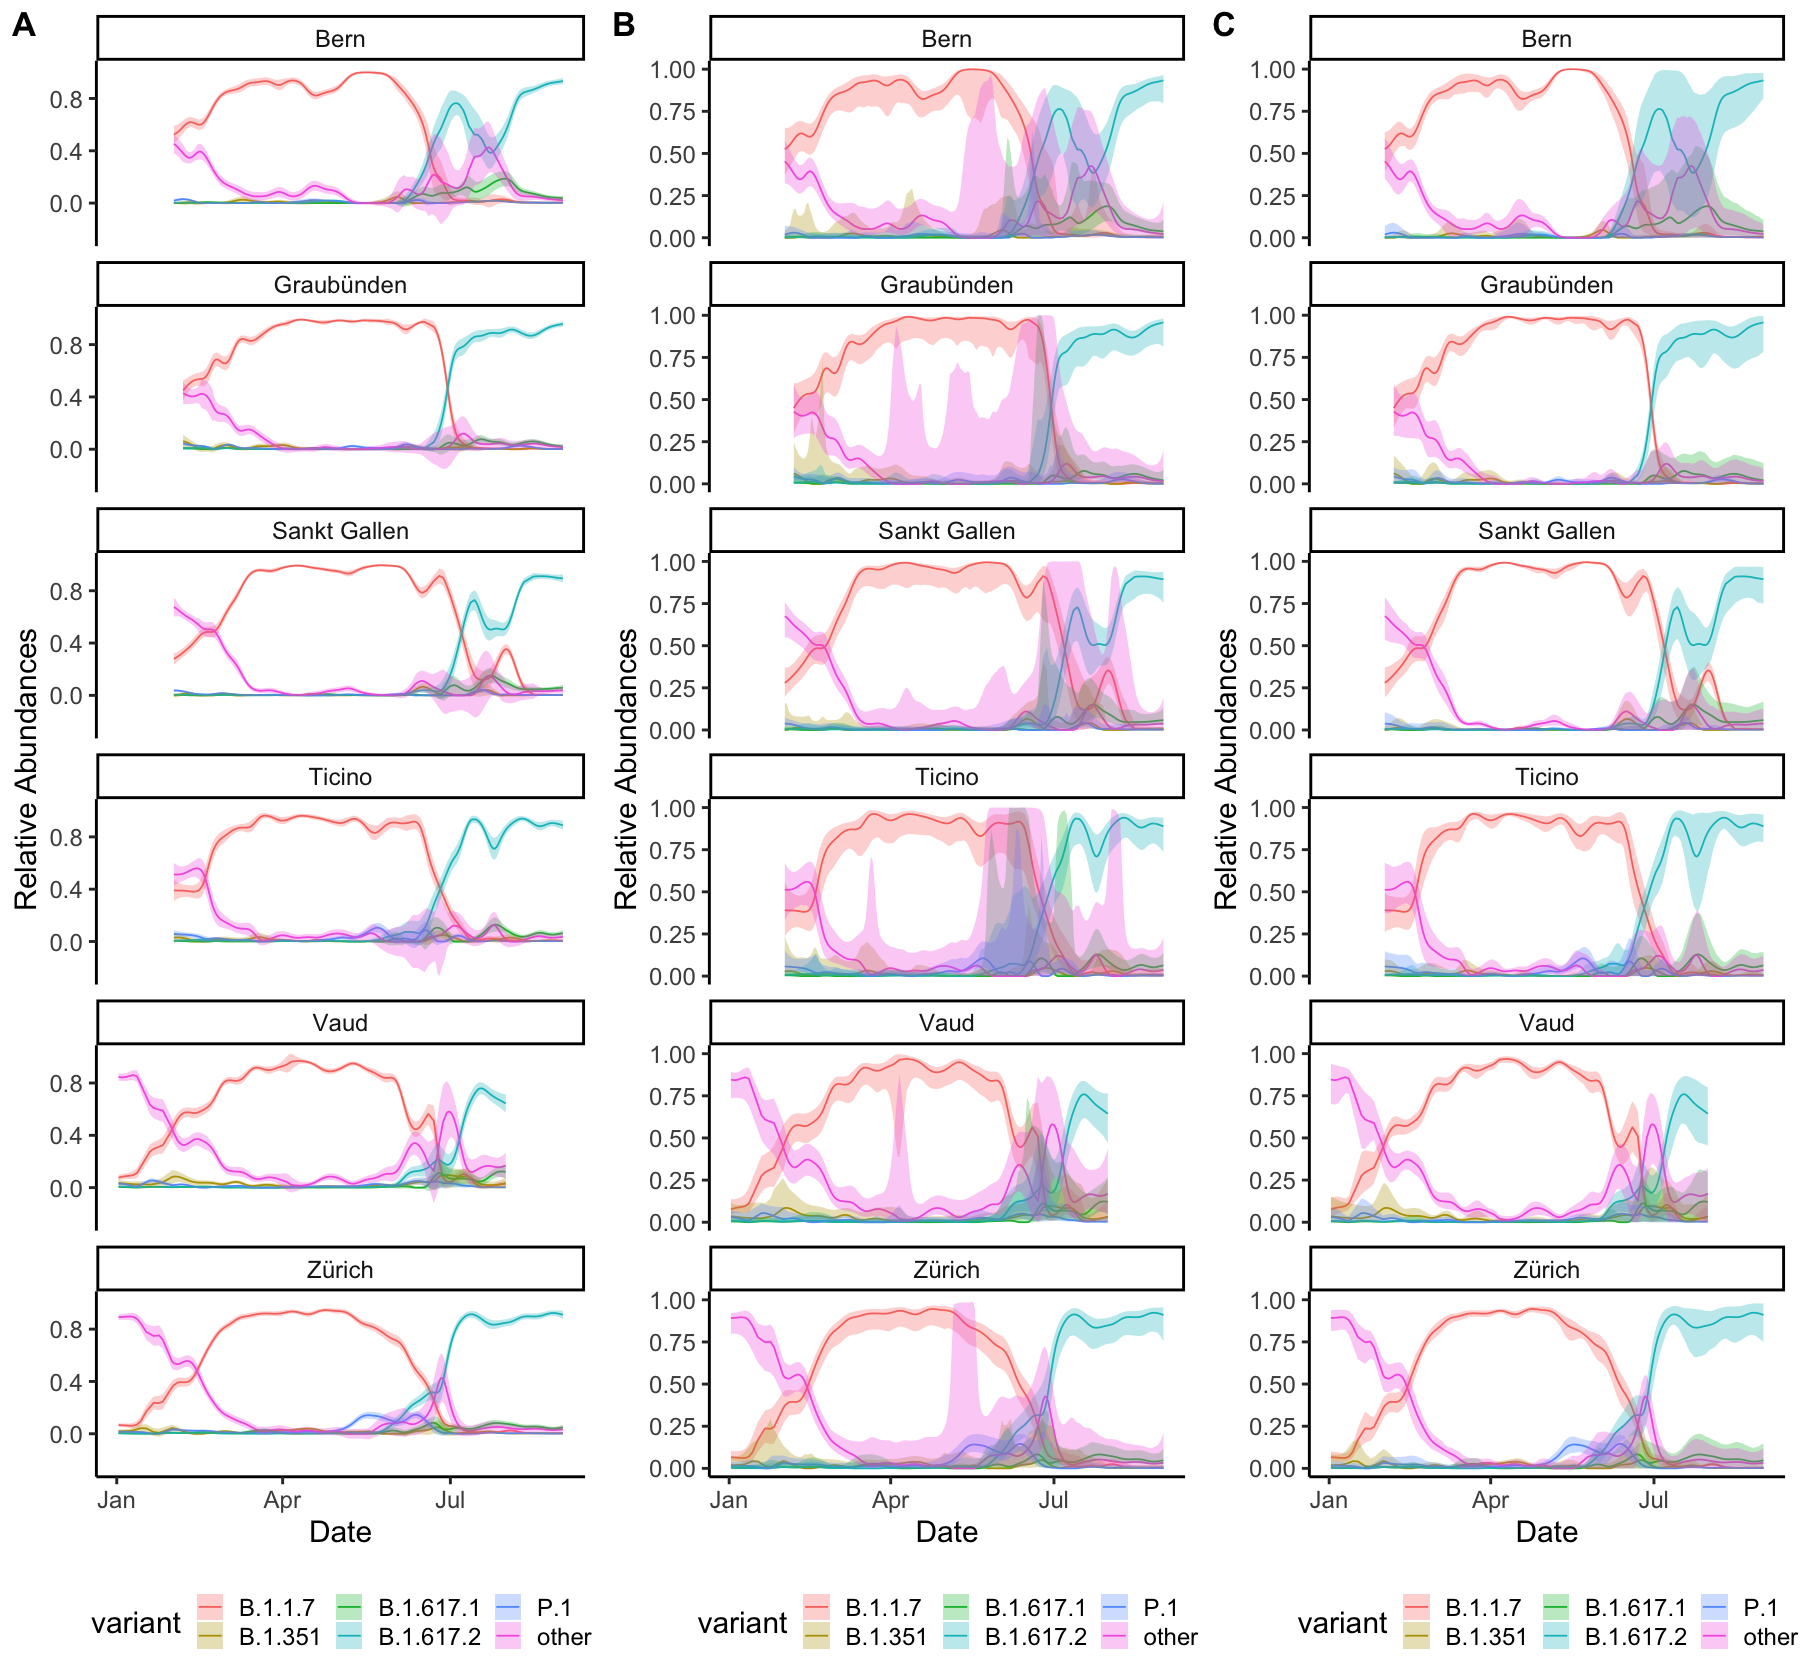

In [32]:
options(repr.plot.width=15, repr.plot.height=14)


ciplt1 <- 
linear_deconv_quasi2_df_flat %>% 
    reshape2::dcast(city + variant + X  ~ estimate, value.var="frac") %>% 
ggplot(data=.) + 
    geom_line(
     aes(
         x = as.Date(X),
         y = MSE, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(X),
         ymin = Wald_lower,
         ymax = Wald_upper, 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

ciplt2 <- 
linear_deconv2_df_flat %>% 
    reshape2::dcast(city + variant + X  ~ estimate, value.var="frac") %>% 
ggplot(data=.) + 
    geom_line(
     aes(
         x = as.Date(X),
         y = MSE, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(X),
         ymin = boot::inv.logit(Wald_lower),
         ymax = boot::inv.logit(Wald_upper), 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

ciplt3 <- 
linear_deconv3_df_boot_flat %>% 
    reshape2::dcast(city + variant + index ~ estimate, value.var="frac") %>% 
ggplot(data=.) + 
    geom_line(
        data = linear_deconv_df_flat[linear_deconv_df_flat$estimate=="MSE",],
     aes(
         x = as.Date(index),
         y = frac, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(index),
         ymin = lower,
         ymax = upper, 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

plot_grid(ciplt1, ciplt2, ciplt3, nrow = 1, labels=LETTERS[1:3], label_size = 20)
ggsave("plots/confint_plt1.pdf", width = 15, height = 14)

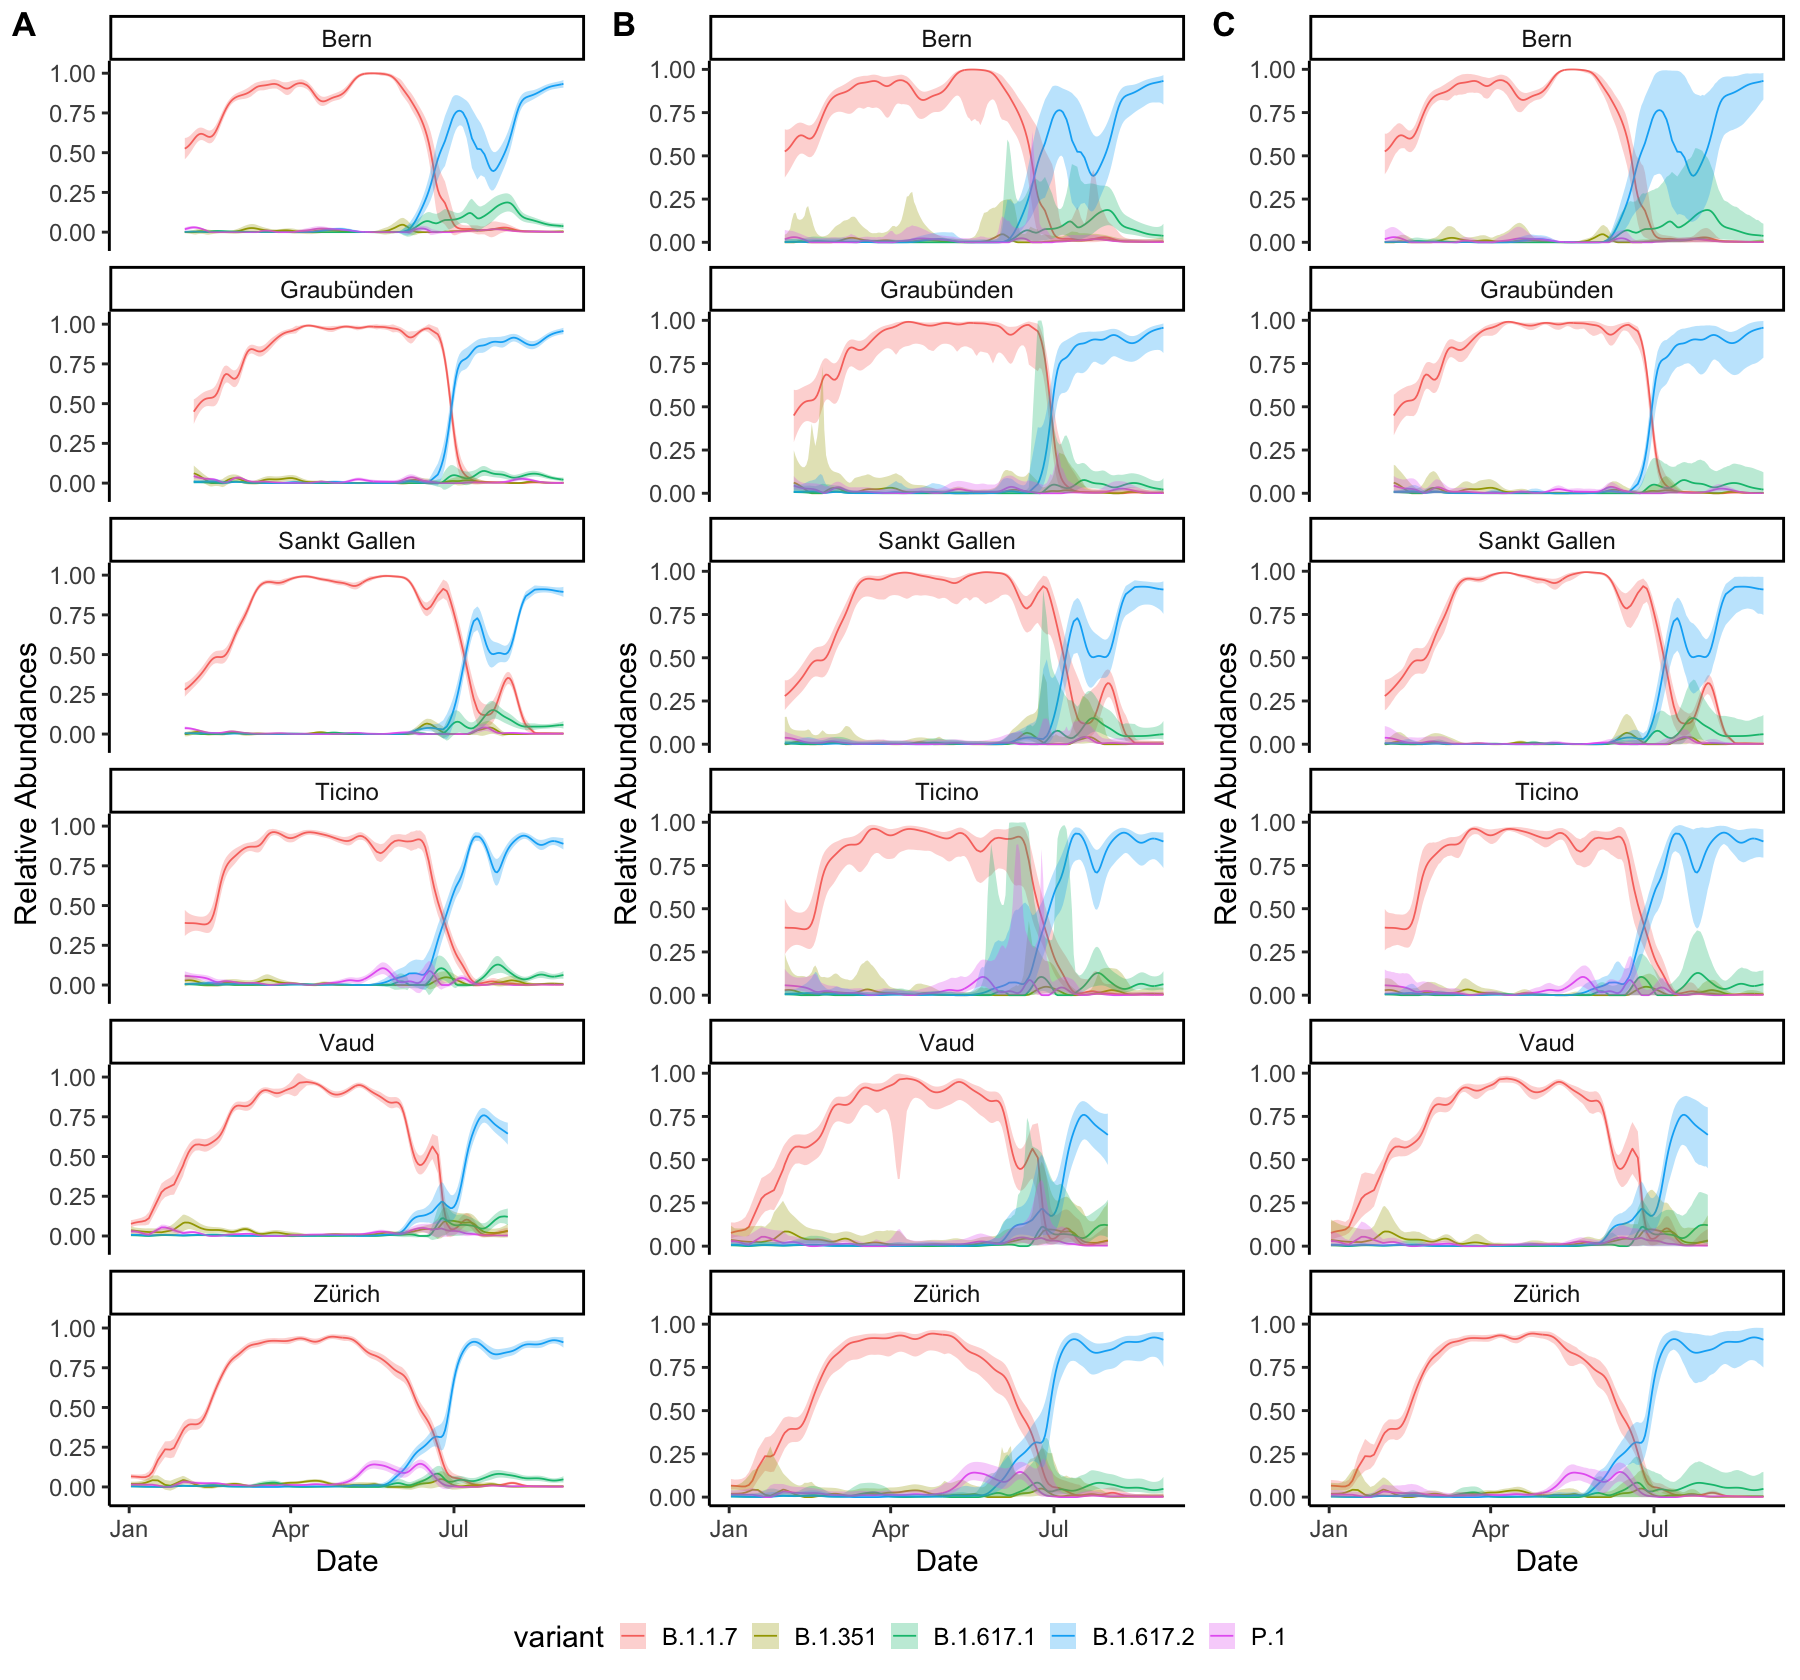

In [33]:
options(repr.plot.width=15, repr.plot.height=14)


ciplt1 <- 
linear_deconv_quasi2_df_flat %>% 
    reshape2::dcast(city + variant + X  ~ estimate, value.var="frac") %>% 
    filter(variant != "other") %>%
ggplot(data=.) + 
    geom_line(
     aes(
         x = as.Date(X),
         y = MSE, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(X),
         ymin = Wald_lower,
         ymax = Wald_upper, 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

ciplt2 <- 
linear_deconv2_df_flat %>% 
    reshape2::dcast(city + variant + X  ~ estimate, value.var="frac") %>% 
    filter(variant != "other") %>%
ggplot(data=.) + 
    geom_line(
     aes(
         x = as.Date(X),
         y = MSE, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(X),
         ymin = boot::inv.logit(Wald_lower),
         ymax = boot::inv.logit(Wald_upper), 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

ciplt3 <- 
linear_deconv3_df_boot_flat %>% 
    reshape2::dcast(city + variant + index ~ estimate, value.var="frac") %>% 
    filter(variant != "other") %>%
ggplot(data=.) + 
    geom_line(
        data = linear_deconv_df_flat[
            (linear_deconv_df_flat$estimate=="MSE") &
            (linear_deconv_df_flat$variant!="other")
            ,],
     aes(
         x = as.Date(index),
         y = frac, 
         color=variant
     )) + 
    geom_ribbon(
     aes(
         x = as.Date(index),
         ymin = lower,
         ymax = upper, 
         fill=variant
     ),
    alpha=0.3) +
    facet_wrap(~city, ncol=1) +
    theme_classic(base_size = 18) +
    labs(x="Date", y="Relative Abundances") +
    theme(legend.position = "bottom")

tmp_leg <- cowplot::get_legend(ciplt2)
ciplt_tot <- plot_grid(
    ciplt1 + theme(legend.position = "none"),
    ciplt2 + theme(legend.position = "none"),
    ciplt3 + theme(legend.position = "none"),
    nrow = 1, labels=LETTERS[1:3], label_size = 20)
plot_grid(ciplt_tot, tmp_leg, nrow = 2, rel_heights = c(18,1))
ggsave("plots/confint_plt2.pdf", width = 15, height = 14)

# Composite plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”


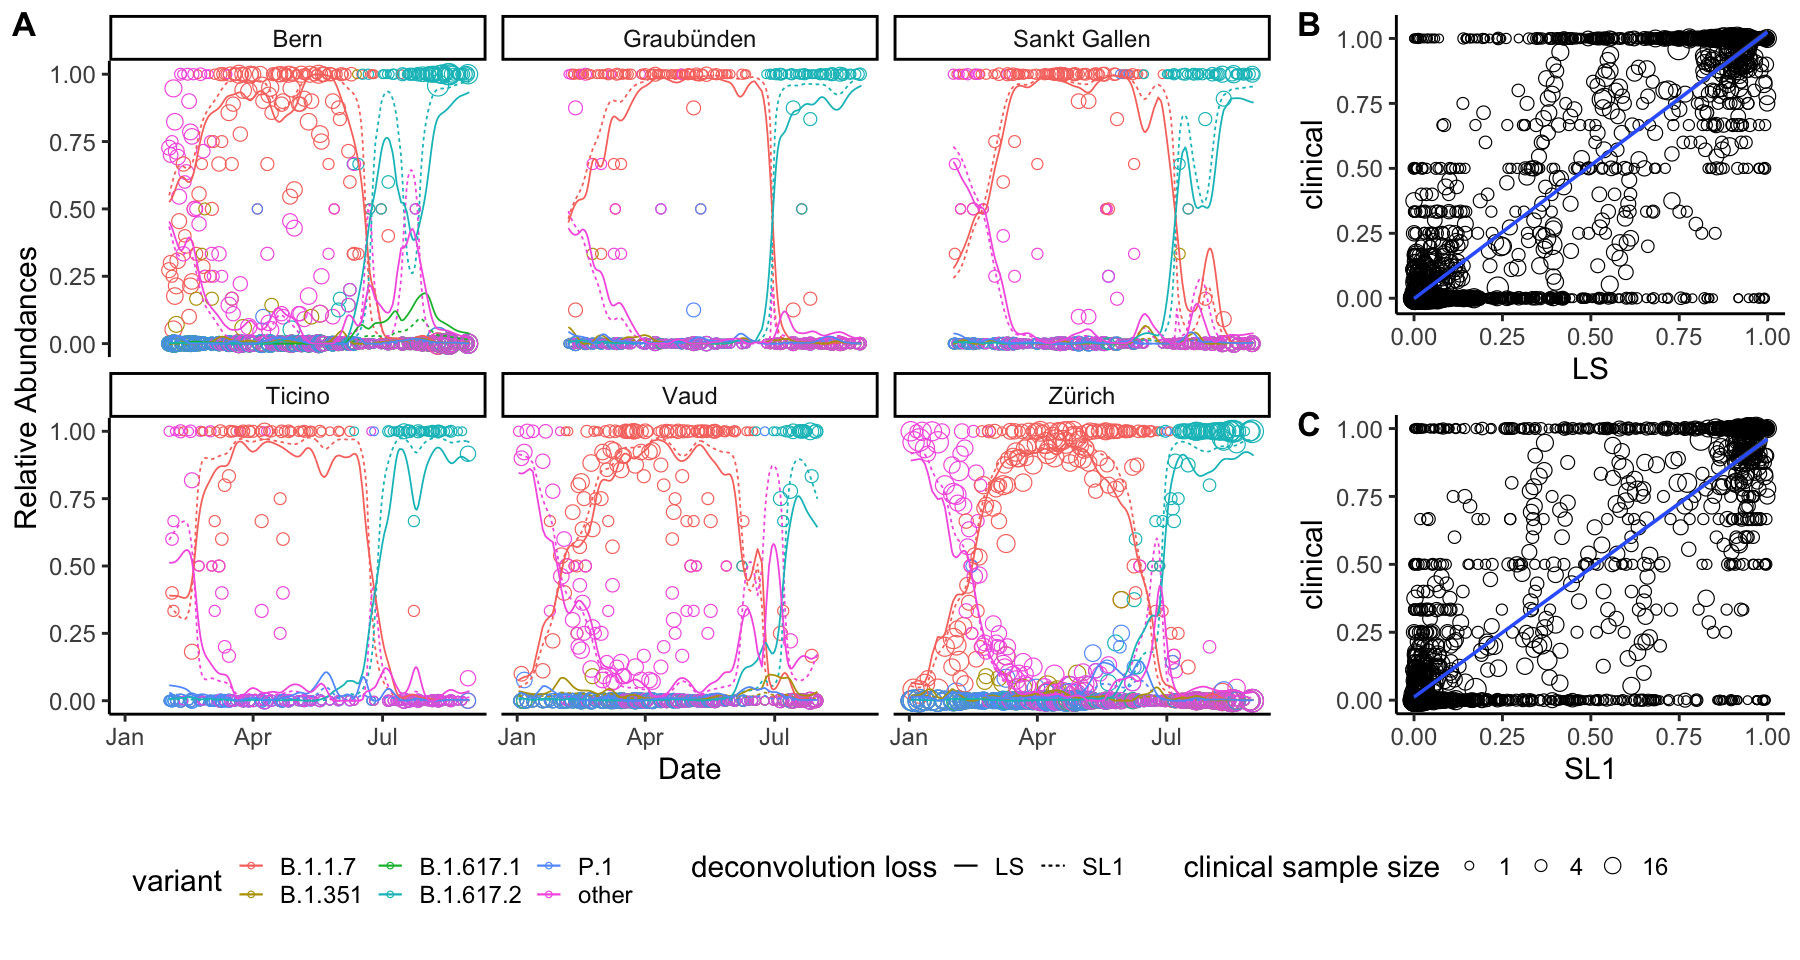

In [34]:
options(repr.plot.width=15, repr.plot.height=8)

corplots <- plot_grid(
    corplot1 + 
        theme(legend.position="none") +
        labs(x="LS", y="clinical"),
    corplot2 + 
        theme(legend.position="none") + 
        labs(x="SL1", y="clinical"),
    ncol=1,
    labels=LETTERS[2:3], label_size=20
)
line_plot_leg <- cowplot::get_legend(line_plot)
comp_plt1 <- plot_grid(
    line_plot + theme(legend.position="none"),
    corplots,
    rel_widths=c(2.5,1),
    labels=LETTERS[1], label_size=20
)

full_plot1 <- plot_grid(comp_plt1, line_plot_leg, ncol=1, rel_heights=c(5,1))
full_plot1
#         line_plot


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”


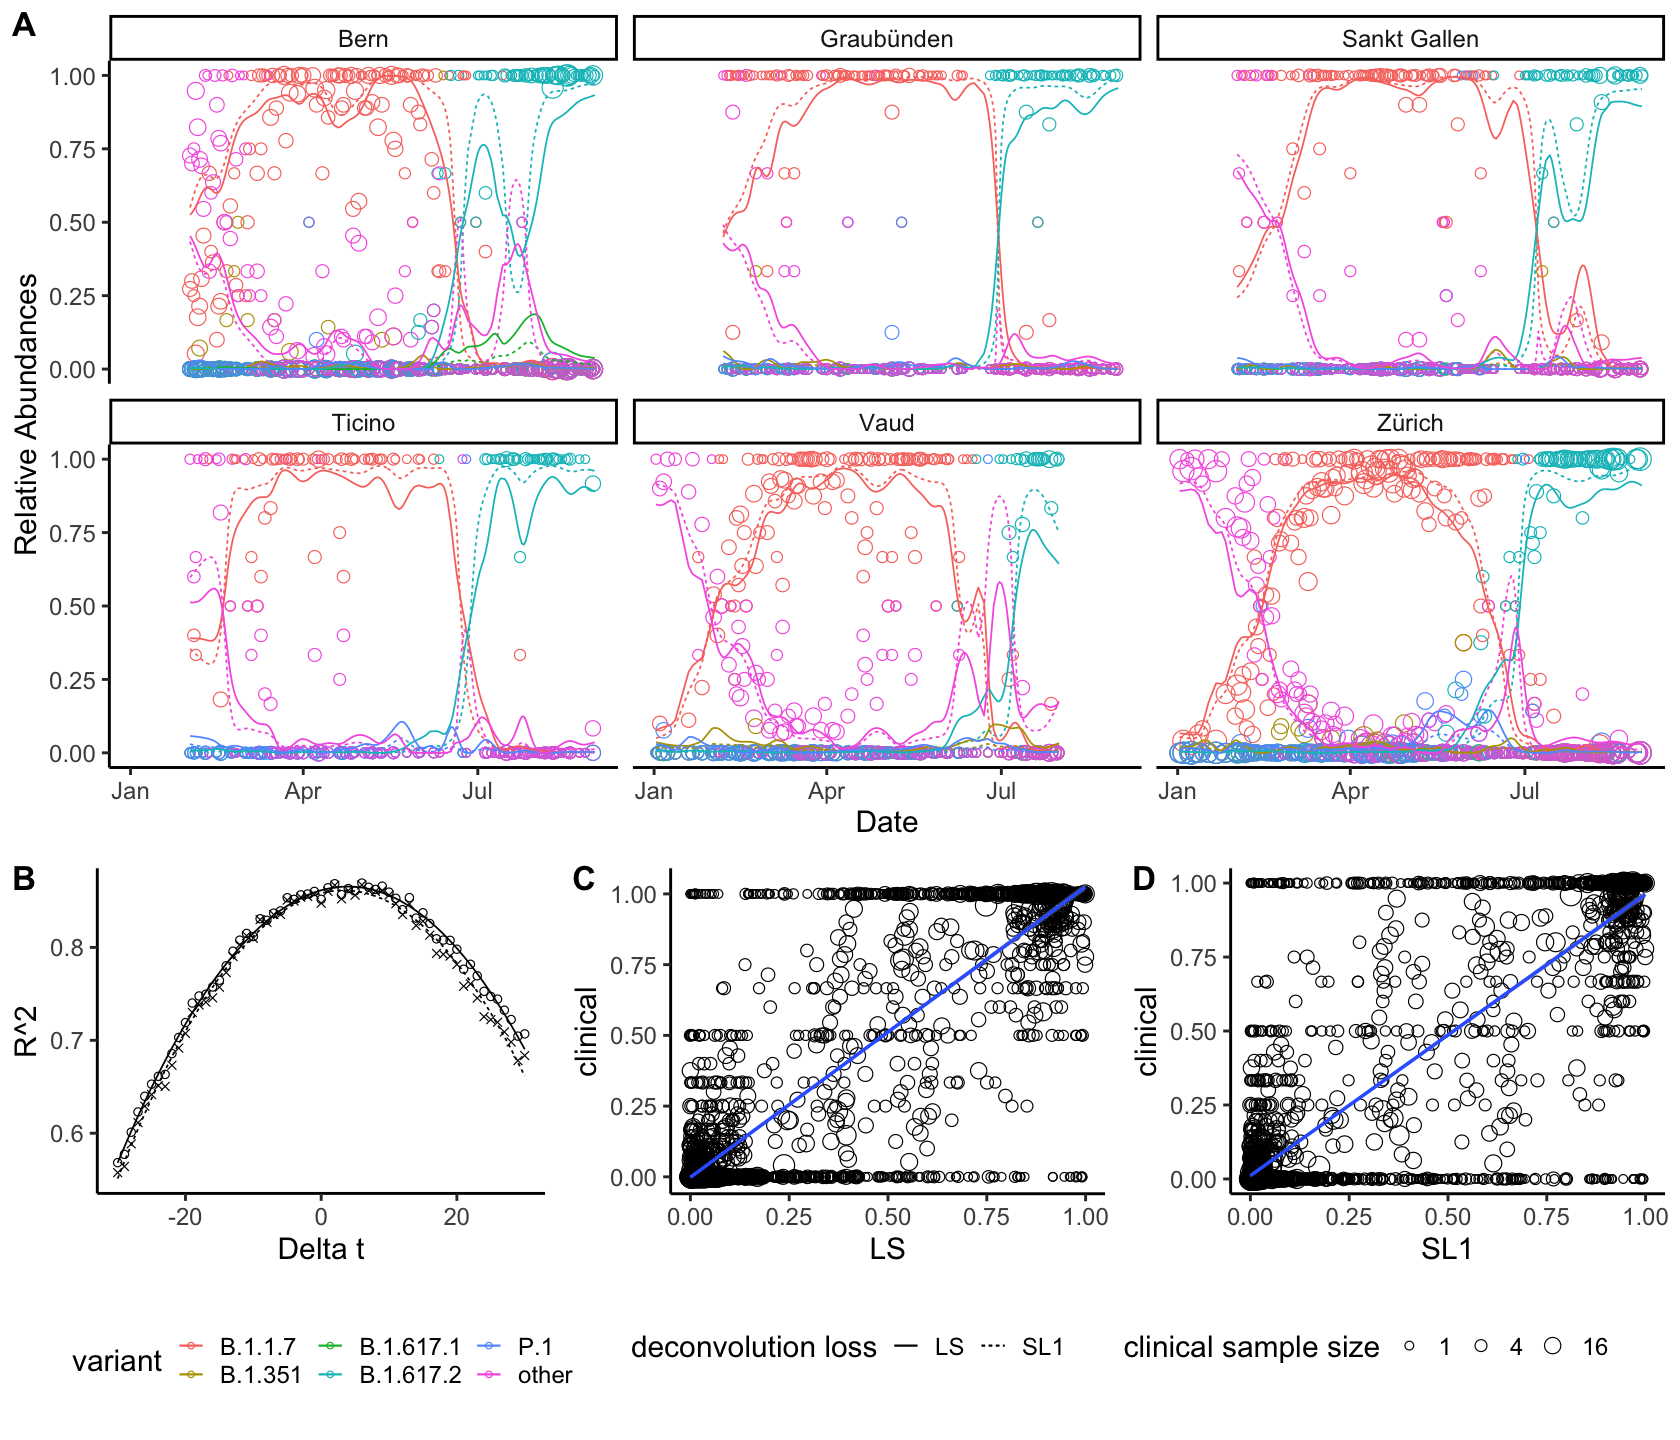

In [35]:
options(repr.plot.width=14, repr.plot.height=12)

corplots <- plot_grid(
    ccf_plot + 
        theme(legend.position="none"),
    corplot1 + 
        theme(legend.position="none") +
        labs(x="LS", y="clinical"),
    corplot2 + 
        theme(legend.position="none") + 
        labs(x="SL1", y="clinical"),
    nrow=1,
    labels=LETTERS[2:4], label_size=20
)
line_plot_leg <- cowplot::get_legend(line_plot)
comp_plt1 <- plot_grid(
    line_plot + theme(legend.position="none"),
    corplots,
    nrow=2,
    rel_heights=c(2,1),
    labels=LETTERS[1], label_size=20
)

full_plot2 <- plot_grid(comp_plt1, line_plot_leg, ncol=1, rel_heights=c(8,1))
full_plot2
#         line_plot


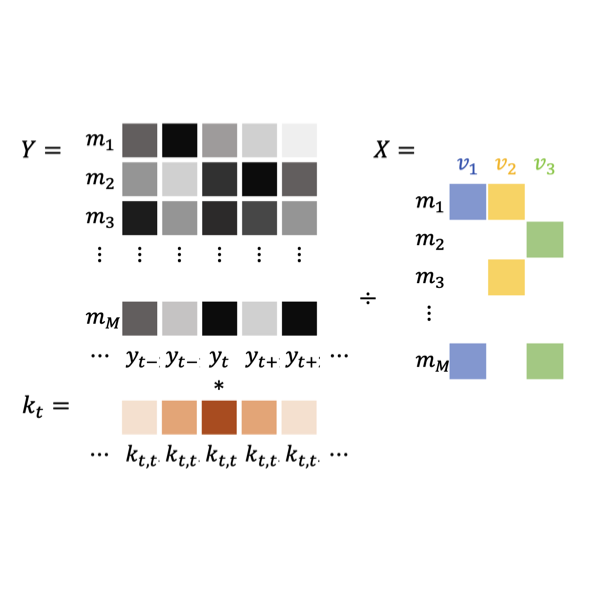

In [36]:
options(repr.plot.width=5, repr.plot.height=5)

subfig1 <- png::readPNG("plots/subfig2.png")
subfig1grob <- grid::rasterGrob(subfig1)

plot_grid(subfig1grob)

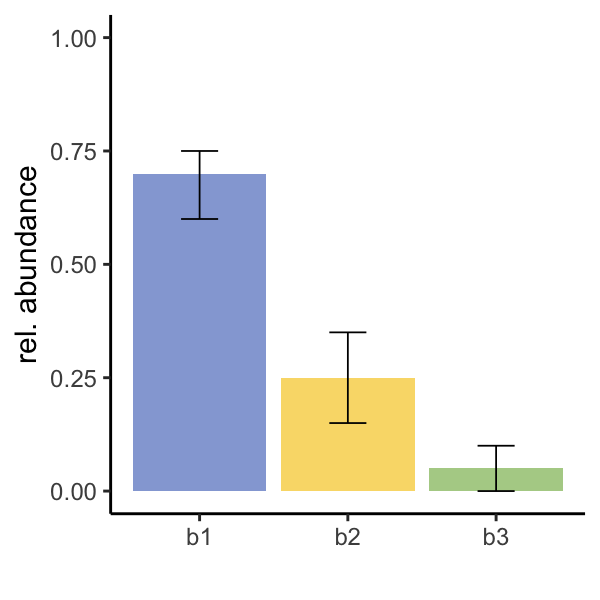

In [37]:
options(repr.plot.width=5, repr.plot.height=5)

plt_dumdec1 <- ggplot() +
 geom_bar(aes(x=paste("b",1:3, sep=""), y=c(0.7, 0.25, 0.05)), stat="identity", fill=c("#95a8d8", "#f9db78", "#b1d095")) +
 geom_errorbar(aes(x=1:3, ymin=c(0.6, 0.15, 0), ymax=c(0.75, 0.35, 0.1)),
               stat="identity", width=0.25) +
labs(x="", y="rel. abundance")+
ylim(c(0,1)) + 
    theme_classic(base_size = 18)

plt_dumdec1

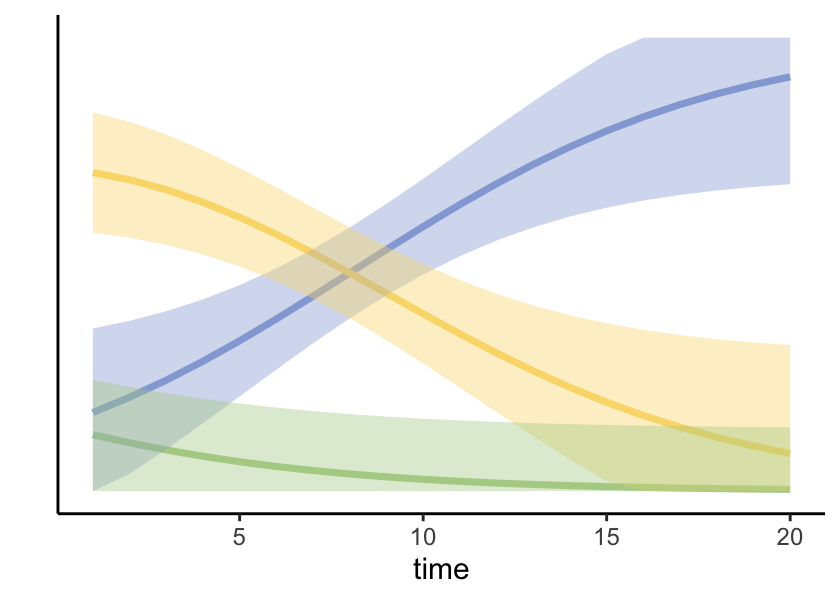

In [38]:
options(repr.plot.width=7, repr.plot.height=5)


times <- 1:20
abund1 <- boot::inv.logit(0.2*(times-8))
abund2 <- 1-abund1
abund3 <- boot::inv.logit(-0.2*(times+8))
abund <- data.frame(V1=abund1, V2=abund2, V3=abund3)
abund <- abund/rowSums(abund)

mycolors <- c("#95a8d8", "#f9db78", "#b1d095")
plt_dumdec2 <- ggplot() +
    geom_line(aes(x=times, y=abund$V1), color=mycolors[1], size=2) +
    geom_line(aes(x=times, y=abund$V2), color=mycolors[2], size=2) +
    geom_line(aes(x=times, y=abund$V3), color=mycolors[3], size=2) +
    geom_ribbon(aes(x=times,
                    ymin=pmax(abund$V1-0.8*(abund$V1-0.5)^2-0.1,0),
                    ymax=pmin(abund$V1+0.8*(abund$V1-0.5)^2+0.1,1)),
                fill=mycolors[1], alpha=0.4) +
    geom_ribbon(aes(x=times,
                    ymin=pmax(abund$V2-0.8*(abund$V2-0.5)^2-0.1,0),
                    ymax=pmin(abund$V2+0.8*(abund$V2-0.5)^2+0.1,1)),
                fill=mycolors[2], alpha=0.4)+
    geom_ribbon(aes(x=times,
                    ymin=pmax(abund$V3-0.2*(abund$V3-0.5)^2-0.1,0),
                    ymax=pmin(abund$V3+0.15*(abund$V3-0.5)^2+0.1,1)),
                fill=mycolors[3], alpha=0.4) +
#     labs(x="time", y="rel. abundance") +
    labs(x="time", y="") +
    theme_classic(base_size = 18) +
    theme(axis.text.y=element_blank(),
      axis.ticks.y=element_blank())    


plt_dumdec2

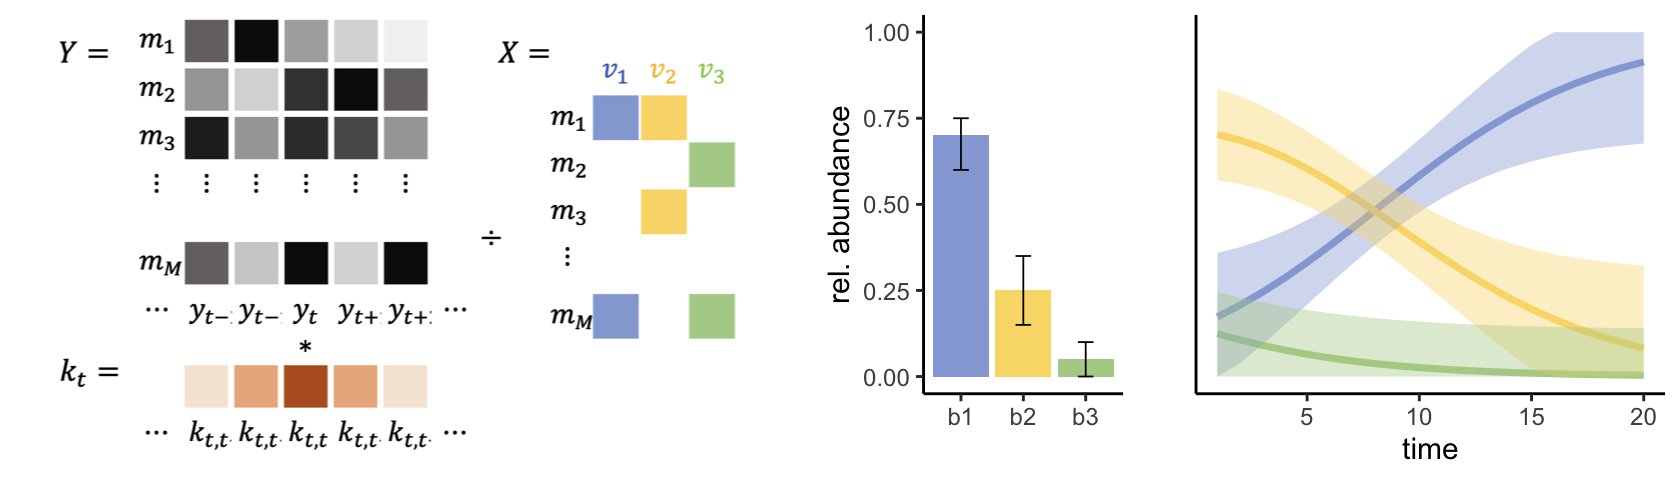

In [39]:
options(repr.plot.width=14, repr.plot.height=4)

examp_plot <- plot_grid(subfig1grob, plt_dumdec2, nrow=1, rel_widths = c(3,2))
examp_plot <- plot_grid(subfig1grob, plt_dumdec1, plt_dumdec2, nrow=1, rel_widths = c(3,1.2,2))

examp_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1392 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”
Warning message:
“Removed 1392 rows containing missing values (geom_point).”


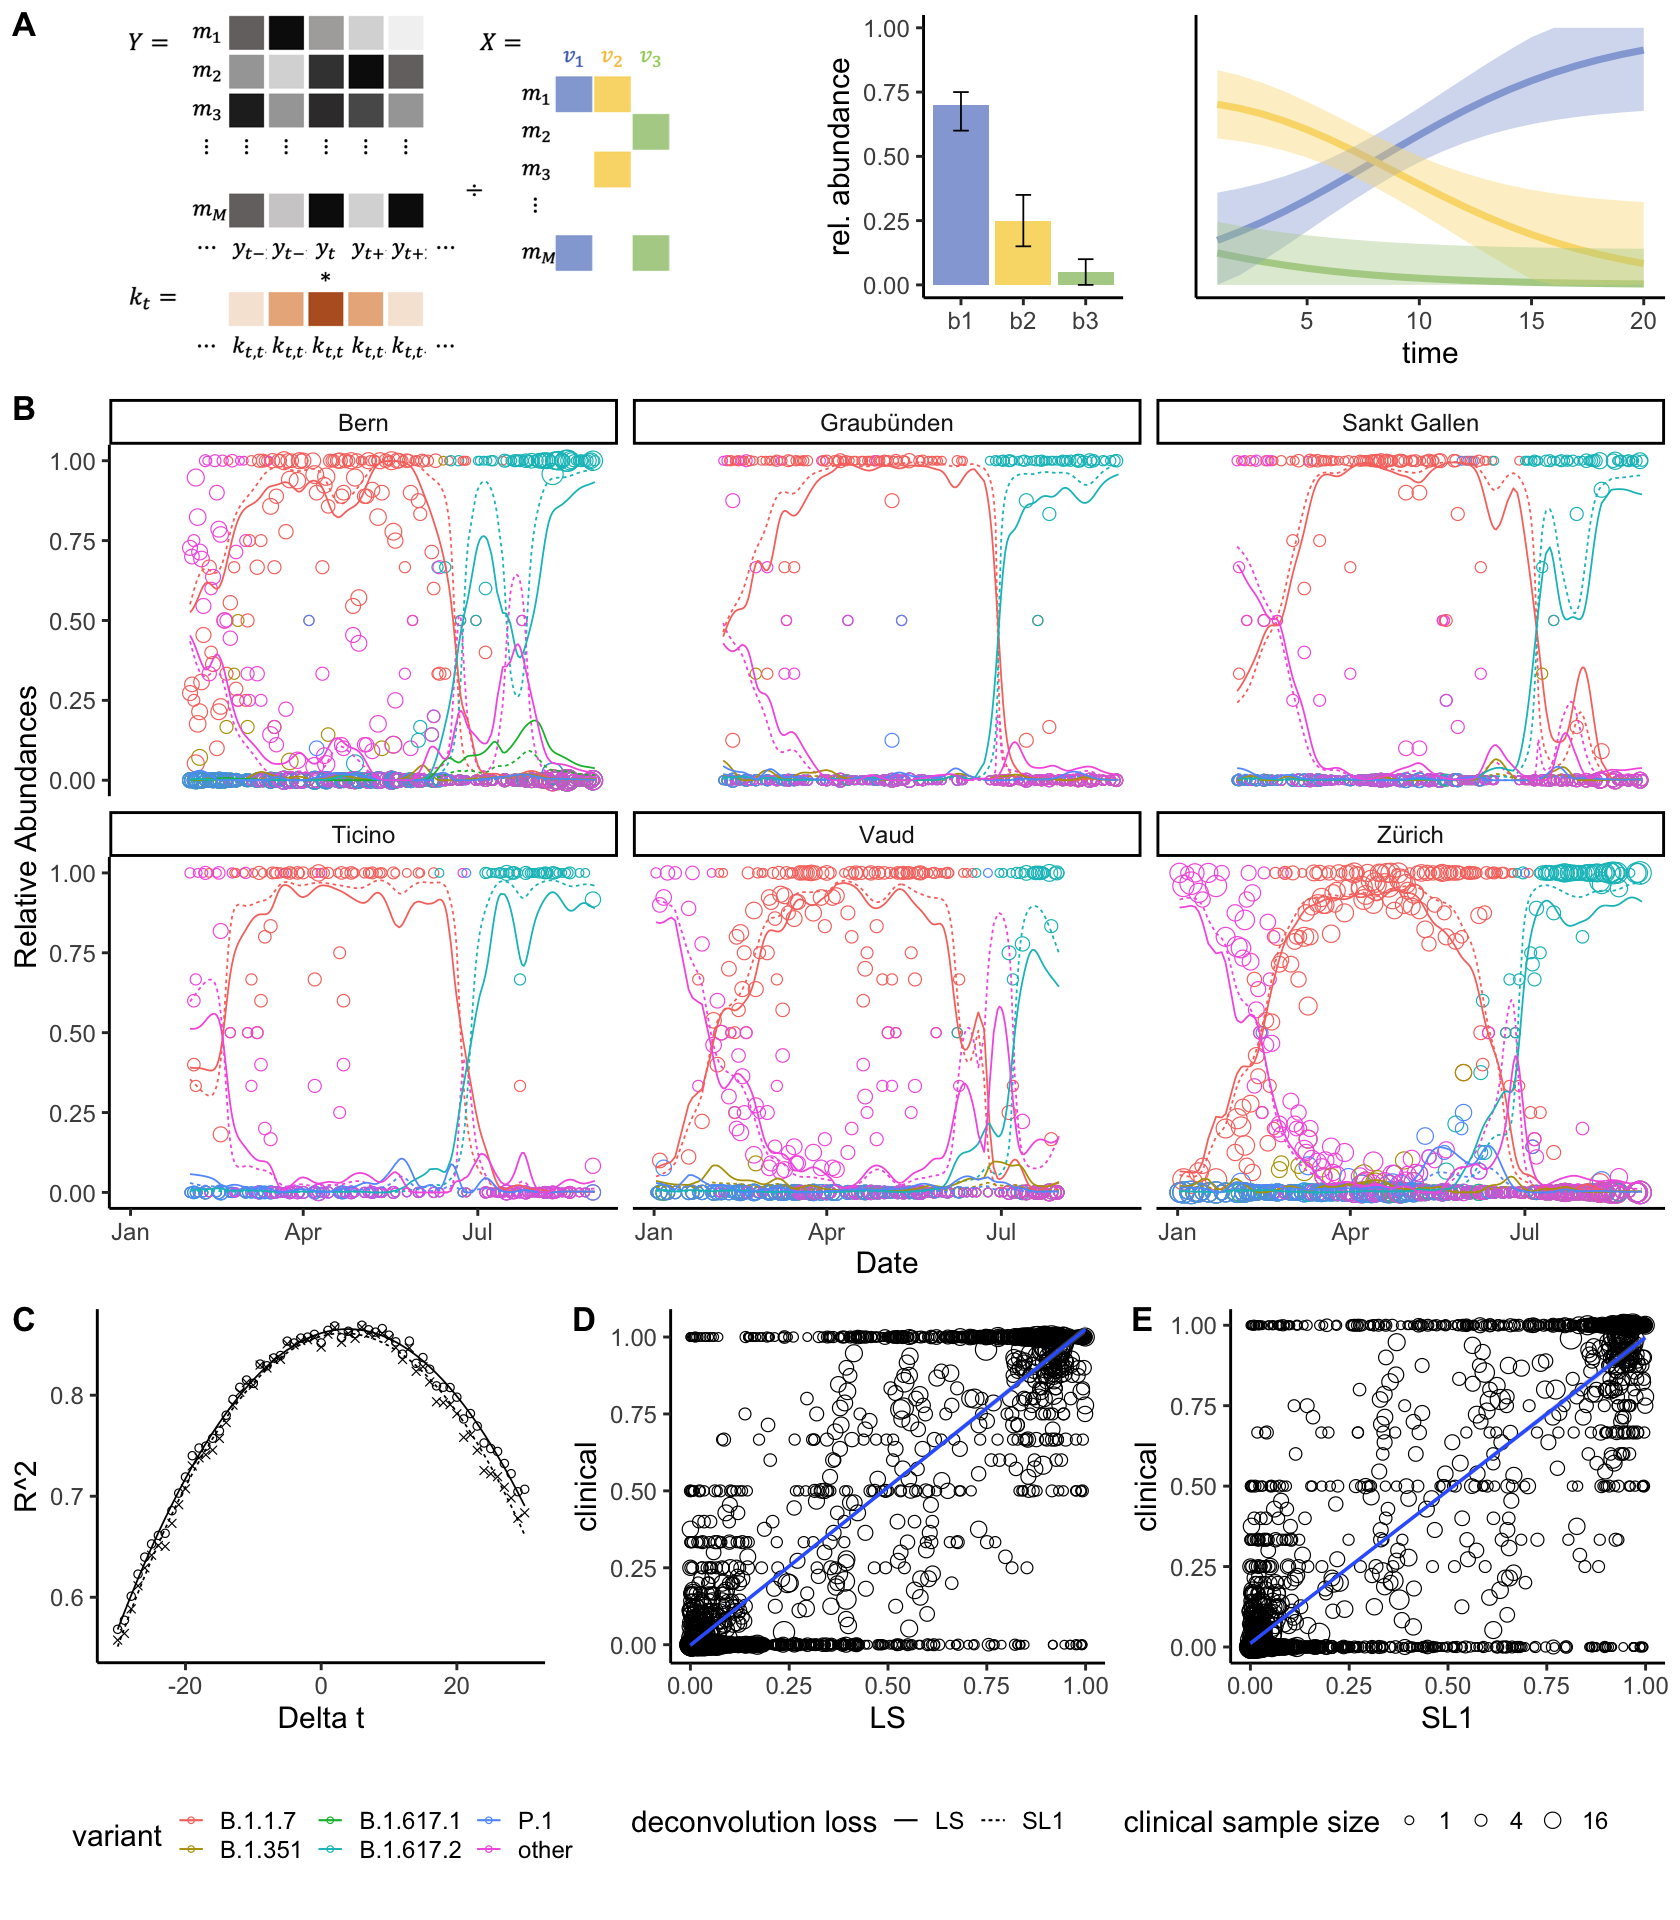

In [40]:
options(repr.plot.width=14, repr.plot.height=16)

corplots <- plot_grid(
    ccf_plot + 
        theme(legend.position="none"),
    corplot1 + 
        theme(legend.position="none") +
        labs(x="LS", y="clinical"),
    corplot2 + 
        theme(legend.position="none") + 
        labs(x="SL1", y="clinical"),
    nrow=1,
    labels=LETTERS[3:5], label_size=20
)
line_plot_leg <- cowplot::get_legend(line_plot)
comp_plt1 <- plot_grid(
    line_plot + theme(legend.position="none"),
    corplots,
    nrow=2,
    rel_heights=c(2,1),
    labels=LETTERS[2], label_size=20
)

full_plot2 <- plot_grid(comp_plt1, line_plot_leg, ncol=1, rel_heights=c(8,1))
full_plot3 <- plot_grid(examp_plot, full_plot2, ncol=1, rel_heights=c(2,8), labels=LETTERS[1], label_size=20)
full_plot3
ggsave("plots/full_plot3.pdf", full_plot3, width = 14, height = 16)
#         line_plot
